# Artistic Style Transfer (Simple Notebook)

This version is cleaned and beginner-friendly.
It uses VGG19 to mix content from one image and style from another.


## 1. Settings


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image
print('TensorFlow:', tf.__version__)


TensorFlow: 2.19.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving content_images.zip to content_images.zip
Saving style_images.zip to style_images.zip


In [ ]:
!unzip content_images.zip

Archive:  content_images.zip
   creating: content_images/
   creating: content_images/architecture/
  inflating: content_images/architecture/architecture_pic1.jpg  
  inflating: content_images/architecture/architecture_pic2.jpg  
   creating: content_images/landscapes/
  inflating: content_images/landscapes/landscapes_pic1.jpg  
  inflating: content_images/landscapes/landscapes_pic2.jpg  
   creating: content_images/portraits/
  inflating: content_images/portraits/portrait_pic1.jpg  
  inflating: content_images/portraits/portrait_pic2.jpg  


In [ ]:
!unzip style_images.zip

Archive:  style_images.zip
   creating: style_images/
   creating: style_images/monet/
  inflating: style_images/monet/monet_pic1.jpeg  
  inflating: style_images/monet/monet_pic2.jpeg  
   creating: style_images/picasso/
  inflating: style_images/picasso/picasso_pic1.jpeg  
  inflating: style_images/picasso/picasso_pic2.jpg  
   creating: style_images/van_gogh/
  inflating: style_images/van_gogh/van_pic1.jpg  
  inflating: style_images/van_gogh/van_pic2.jpg  


In [ ]:
content_path = 'content_images/architecture/architecture_pic2.jpg'
style_path = 'style_images/van_gogh/van_pic1.jpg'
output_path = 'outputs/stylized_beginner.jpg'

image_size = 512
epochs = 500
learning_rate = 0.03
content_weight = 1e4
style_weight = 1e2


## 2. Helper Functions


In [ ]:
def load_image(path, size=image_size):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (size, size))
    img = tf.expand_dims(img, axis=0)
    return img

def show_image(img, title='Image'):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.squeeze(img))
    plt.axis('off')
    plt.title(title)
    plt.show()

def save_image(img, path):
    arr = tf.squeeze(img).numpy()
    arr = np.clip(arr * 255, 0, 255).astype('uint8')
    Image.fromarray(arr).save(path)


## 3. Build VGG19 Feature Models


In [ ]:
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
vgg.trainable = False

content_model = tf.keras.Model(vgg.input, vgg.get_layer(content_layer).output)
style_model = tf.keras.Model(vgg.input, [vgg.get_layer(name).output for name in style_layers])

def gram_matrix(x):
    channels = x.shape[-1]
    features = tf.reshape(x, (-1, channels))
    gram = tf.matmul(features, features, transpose_a=True)
    n = tf.cast(tf.shape(features)[0], tf.float32)
    return gram / n

def content_loss(content_features, generated_features):
    return tf.reduce_mean(tf.square(content_features - generated_features))

def style_loss(style_features, generated_features):
    loss = 0.0
    for s, g in zip(style_features, generated_features):
        loss += tf.reduce_mean(tf.square(gram_matrix(s) - gram_matrix(g)))
    return loss


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## 4. Load and Preview Images


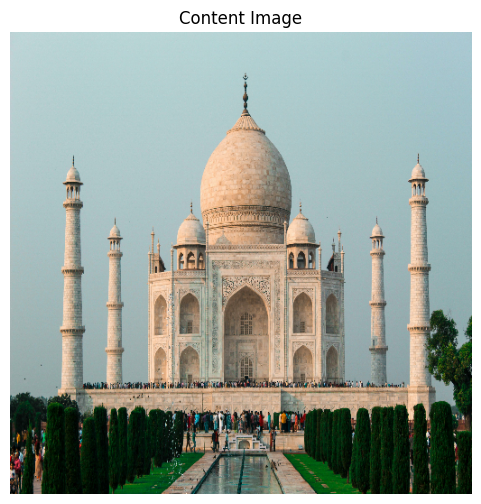

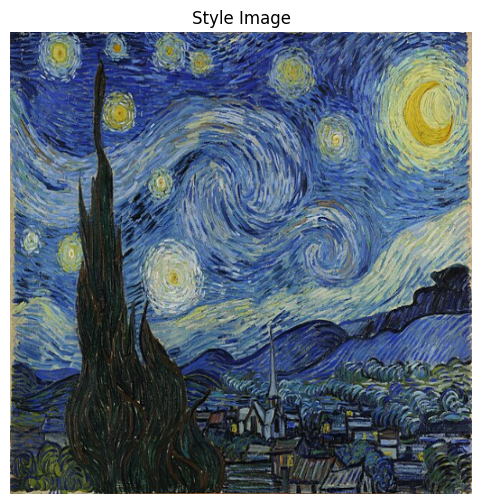

In [ ]:
content_img = load_image(content_path)
style_img = load_image(style_path)

show_image(content_img, 'Content Image')
show_image(style_img, 'Style Image')


## 5. Optimize the Output Image


In [ ]:
generated_img = tf.Variable(content_img)
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

target_content = content_model(content_img)
target_style = style_model(style_img)

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        gen_content = content_model(generated_img)
        gen_style = style_model(generated_img)

        c_loss = content_loss(target_content, gen_content)
        s_loss = style_loss(target_style, gen_style)
        total_loss = content_weight * c_loss + style_weight * s_loss

    grad = tape.gradient(total_loss, generated_img)
    optimizer.apply_gradients([(grad, generated_img)])
    generated_img.assign(tf.clip_by_value(generated_img, 0.0, 1.0))

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{epochs} | Total: {total_loss.numpy():.2f} | Content: {c_loss.numpy():.4f} | Style: {s_loss.numpy():.4f}')


Epoch 1/500 | Total: 1195874.75 | Content: 0.0000 | Style: 11958.7471
Epoch 20/500 | Total: 36701.16 | Content: 0.8384 | Style: 283.1728
Epoch 40/500 | Total: 13455.76 | Content: 0.6487 | Style: 69.6882
Epoch 60/500 | Total: 8644.46 | Content: 0.5221 | Style: 34.2361
Epoch 80/500 | Total: 6860.69 | Content: 0.4377 | Style: 24.8412
Epoch 100/500 | Total: 5921.10 | Content: 0.3869 | Style: 20.5241
Epoch 120/500 | Total: 5293.76 | Content: 0.3509 | Style: 17.8452
Epoch 140/500 | Total: 4830.34 | Content: 0.3235 | Style: 15.9515
Epoch 160/500 | Total: 4474.85 | Content: 0.3024 | Style: 14.5125
Epoch 180/500 | Total: 4190.17 | Content: 0.2851 | Style: 13.3960
Epoch 200/500 | Total: 3957.07 | Content: 0.2707 | Style: 12.4967
Epoch 220/500 | Total: 3764.03 | Content: 0.2588 | Style: 11.7606
Epoch 240/500 | Total: 3599.28 | Content: 0.2485 | Style: 11.1438
Epoch 260/500 | Total: 3455.96 | Content: 0.2393 | Style: 10.6289
Epoch 280/500 | Total: 3331.05 | Content: 0.2311 | Style: 10.2027
Epoch 3

## 6. Show and Save Result


In [ ]:
img = tf.squeeze(generated_img)
img = tf.clip_by_value(img, 0.0, 1.0)
img = img * 255.0
img = tf.cast(img, tf.uint8)
img = img.numpy()

img = Image.fromarray(img)

img.save("stylized_output.jpg")

print("Saved as stylized_output.jpg")


Saved as stylized_output.jpg


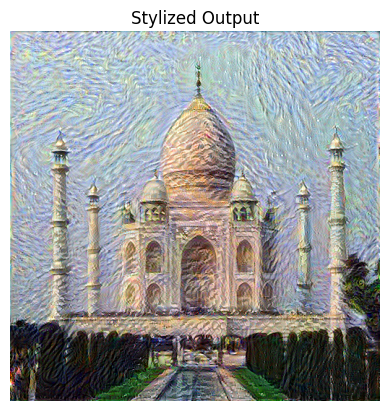

In [ ]:
plt.imshow(img)
plt.axis("off")
plt.title("Stylized Output")
plt.show()